In [1]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import os
import sys
import csv
import talib
from   scipy.stats       import norm
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import mplfinance        as mpf

In [2]:
df_ = pd.read_csv("./data/BTCUSDT.csv", parse_dates=True)
df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
del df_['datetime']

In [3]:
timeframe_by_minute = 30

In [4]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.32,4261.45,11.308926
2017-08-17 04:30:00,4280.00,4313.62,4267.99,4308.83,35.872083
2017-08-17 05:00:00,4308.83,4328.69,4304.31,4320.00,21.048648
2017-08-17 05:30:00,4320.00,4320.00,4291.37,4315.32,2.186268
2017-08-17 06:00:00,4315.32,4330.29,4309.37,4311.02,3.566277
...,...,...,...,...,...
2023-07-31 21:30:00,29196.00,29259.40,29189.99,29243.31,245.053720
2023-07-31 22:00:00,29243.32,29243.32,29214.06,29237.05,307.222980
2023-07-31 22:30:00,29237.04,29237.05,29201.00,29209.99,134.227690


mean    : 50.64896635776809
std.dev : 11.695410194186103
sigma lower : 27.3
sigma upper : 74.0


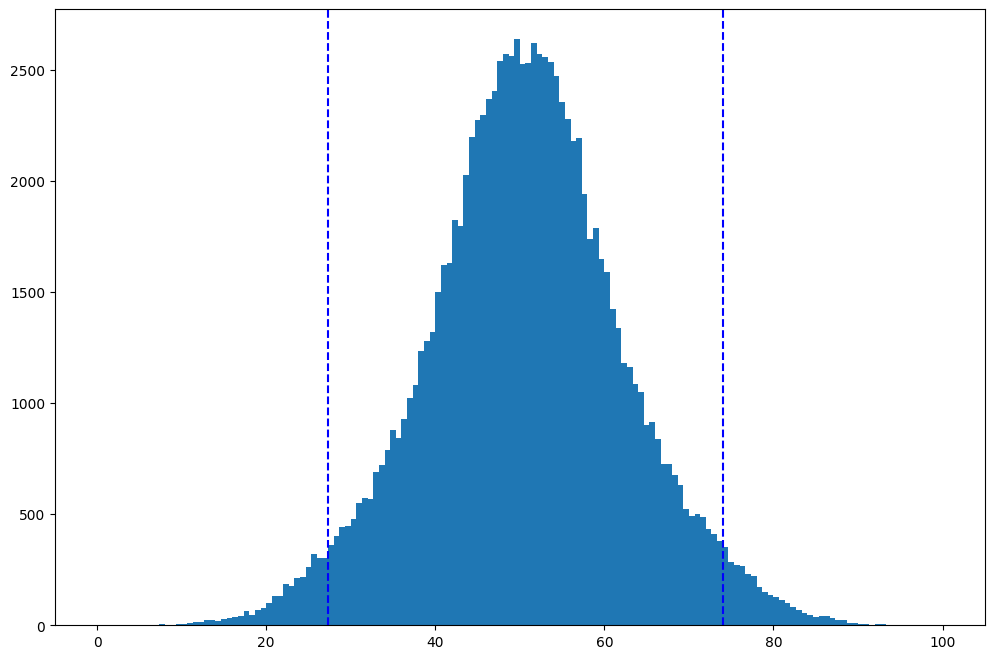

In [5]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [6]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
 1.0    953
-1.0    883
Name: count, dtype: int64

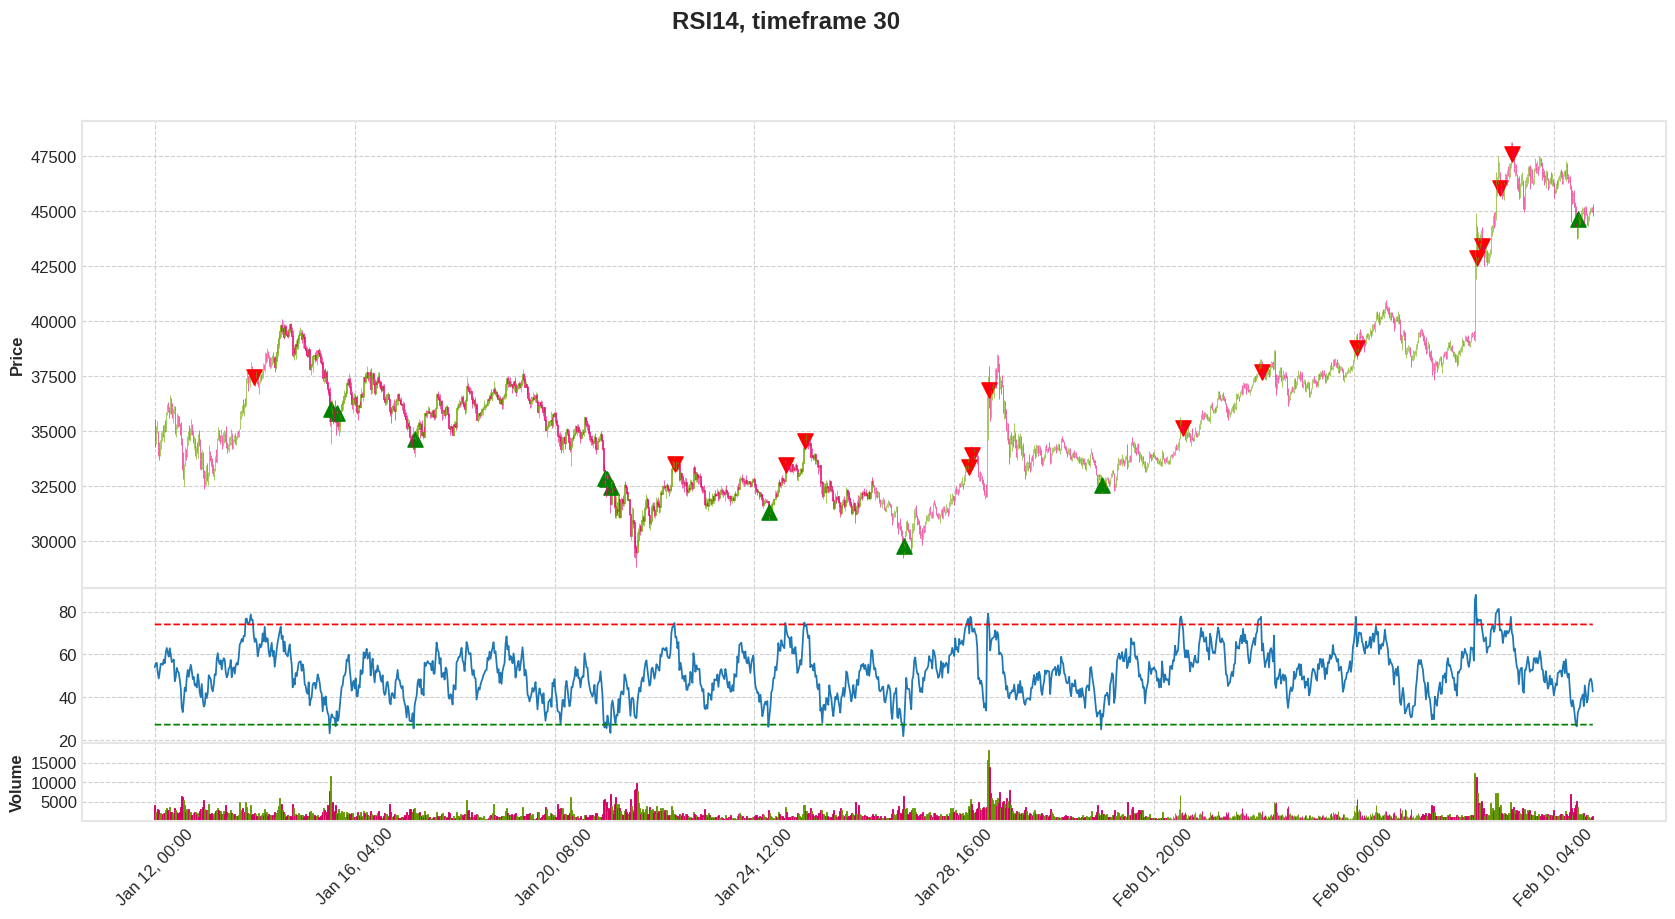

In [8]:
plot_df = df["2021-01-12":"2021-02-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=120, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=120, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [9]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

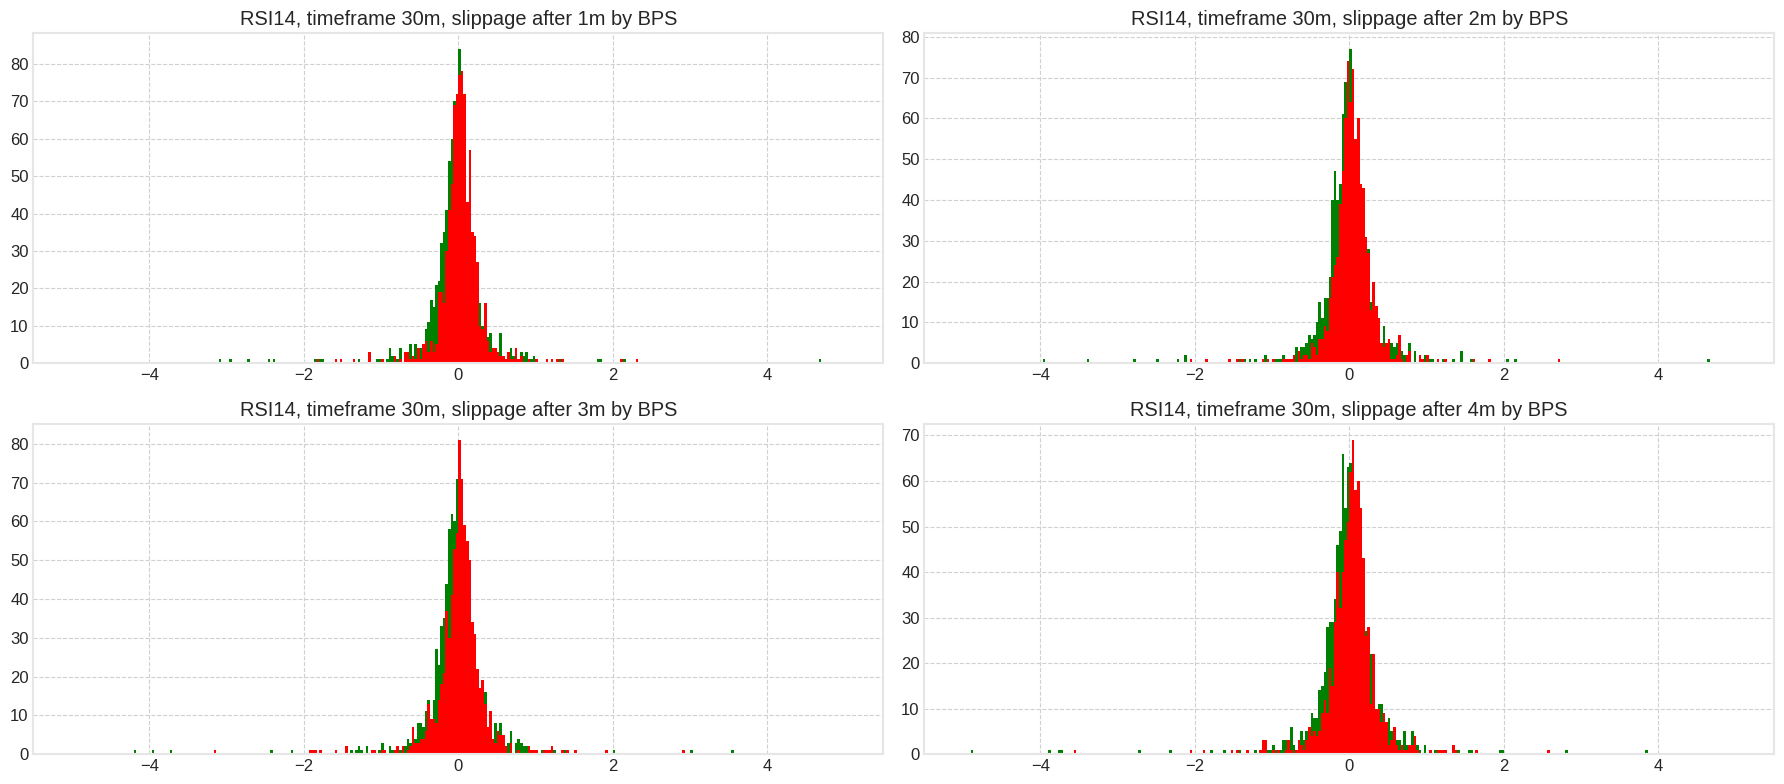

In [10]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-5.0, 5.0)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();

In [11]:
df_ = pd.read_csv("./data/BTCUSDT.csv", parse_dates=True)
df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
del df_['datetime']

In [12]:
timeframe_by_hours  = 1
timeframe_by_minute = timeframe_by_hours*60

In [13]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4315.32,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4324.35,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2023-07-31 19:00:00,29195.74,29237.54,29101.80,29157.48,1346.132320
2023-07-31 20:00:00,29157.49,29257.99,29115.64,29208.27,1340.235410
2023-07-31 21:00:00,29208.28,29295.24,29158.46,29243.31,865.687950


mean    : 50.73952834568203
std.dev : 12.32042641742705
sigma lower : 26.1
sigma upper : 75.4


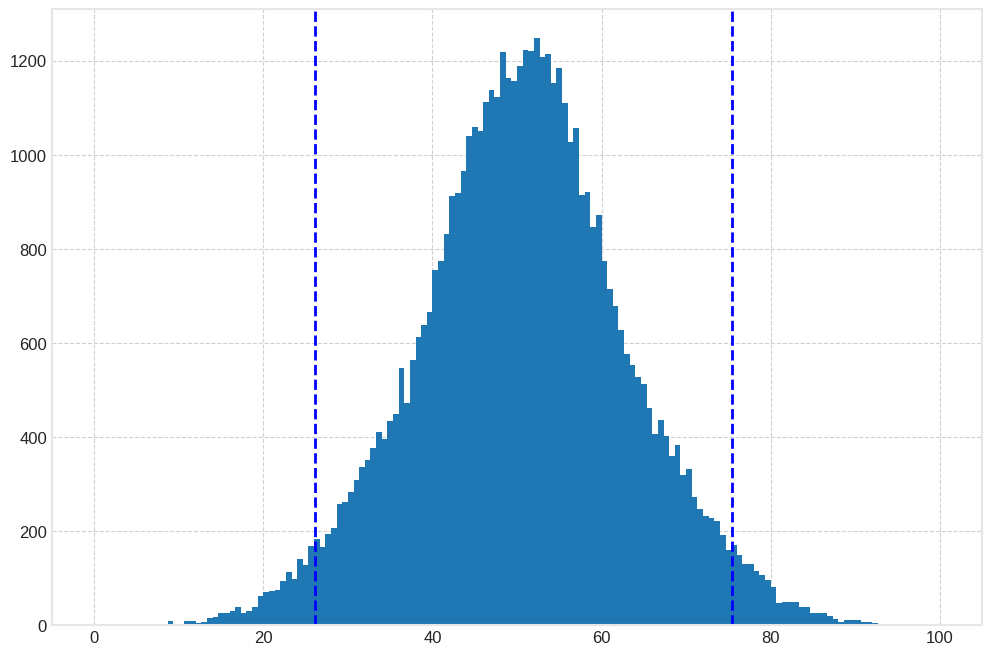

In [14]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [15]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
 1.0    435
-1.0    417
Name: count, dtype: int64

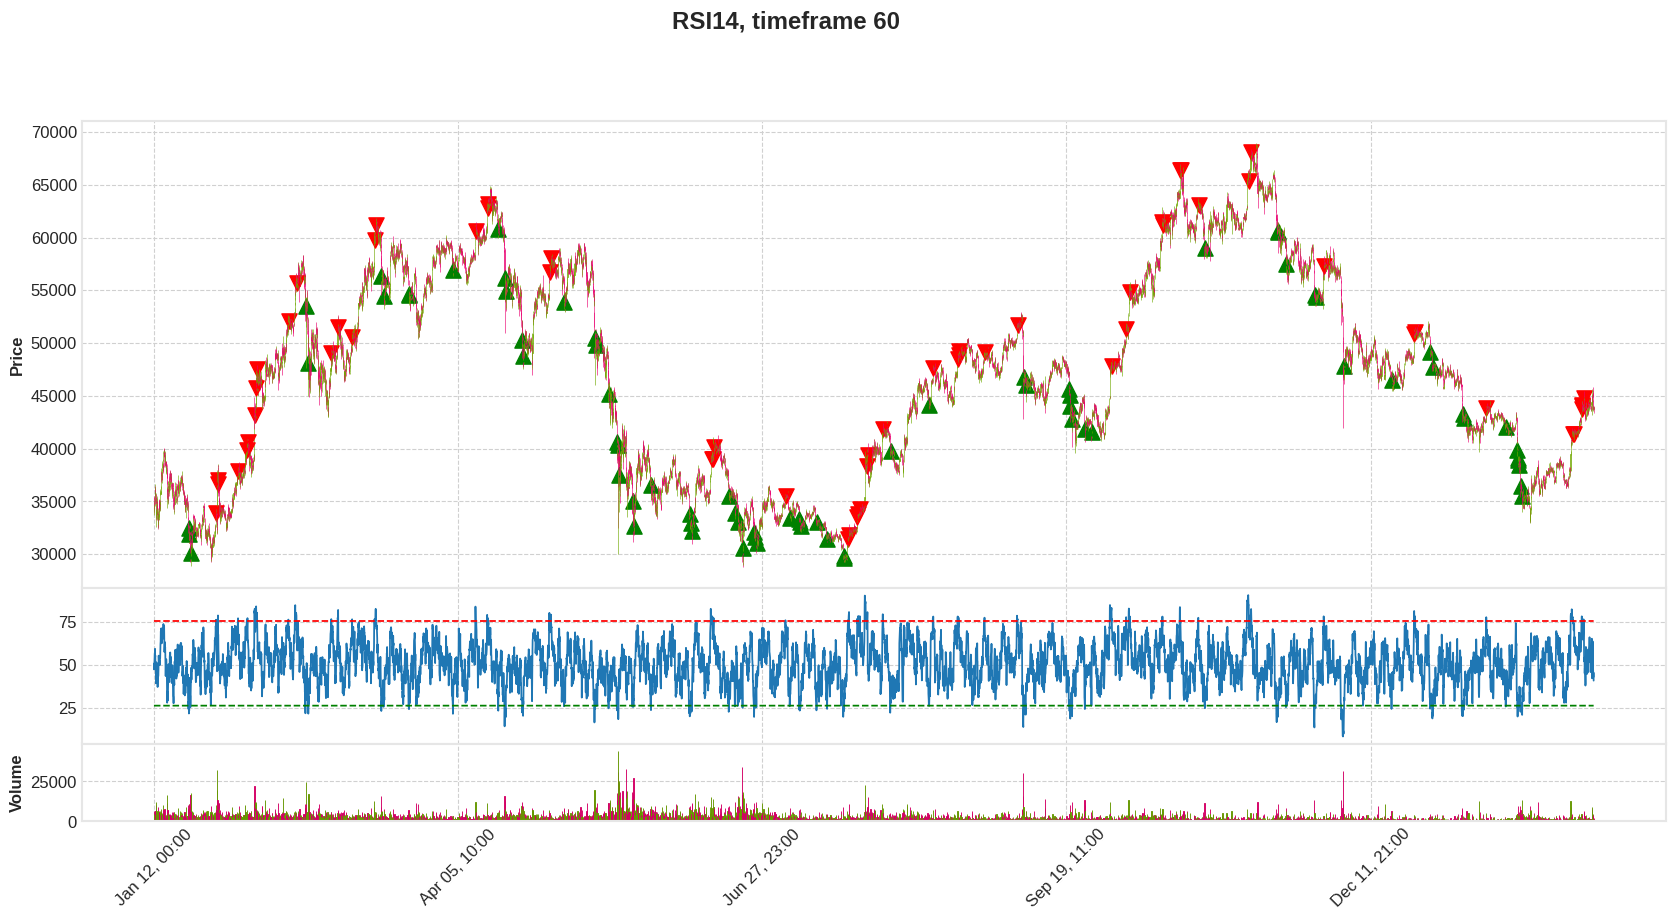

In [16]:
plot_df = df["2021-01-12":"2022-02-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=120, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=120, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [17]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

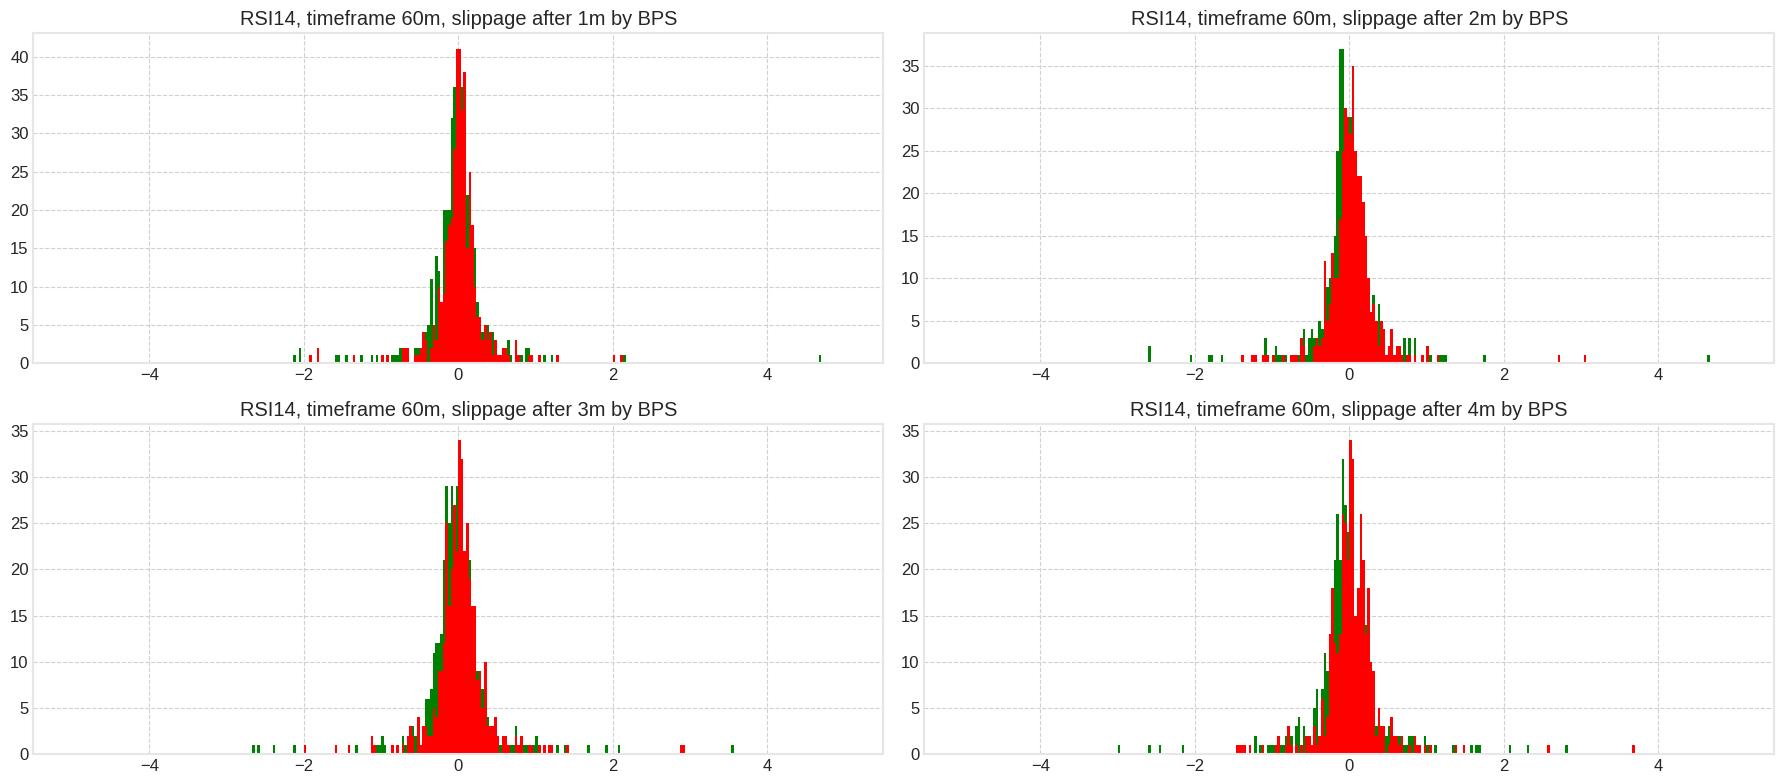

In [18]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-5.0, 5.0)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();

In [19]:
df_ = pd.read_csv("./data/BTCUSDT.csv", parse_dates=True)
df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
del df_['datetime']

In [20]:
timeframe_by_hours  = 4
timeframe_by_minute = timeframe_by_hours*60

In [21]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865
2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882
2017-08-17 12:00:00,4427.30,4485.39,4333.42,4352.34,174.562001
2017-08-17 16:00:00,4352.34,4354.84,4200.74,4325.23,225.109716
2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913
...,...,...,...,...,...
2023-07-31 04:00:00,29422.00,29443.68,29360.66,29373.61,2975.903810
2023-07-31 08:00:00,29373.62,29420.06,29332.32,29405.99,3067.699010
2023-07-31 12:00:00,29405.99,29473.97,29225.97,29247.98,4845.779300


mean    : 51.141223656656386
std.dev : 13.329655154863493
sigma lower : 24.5
sigma upper : 77.8


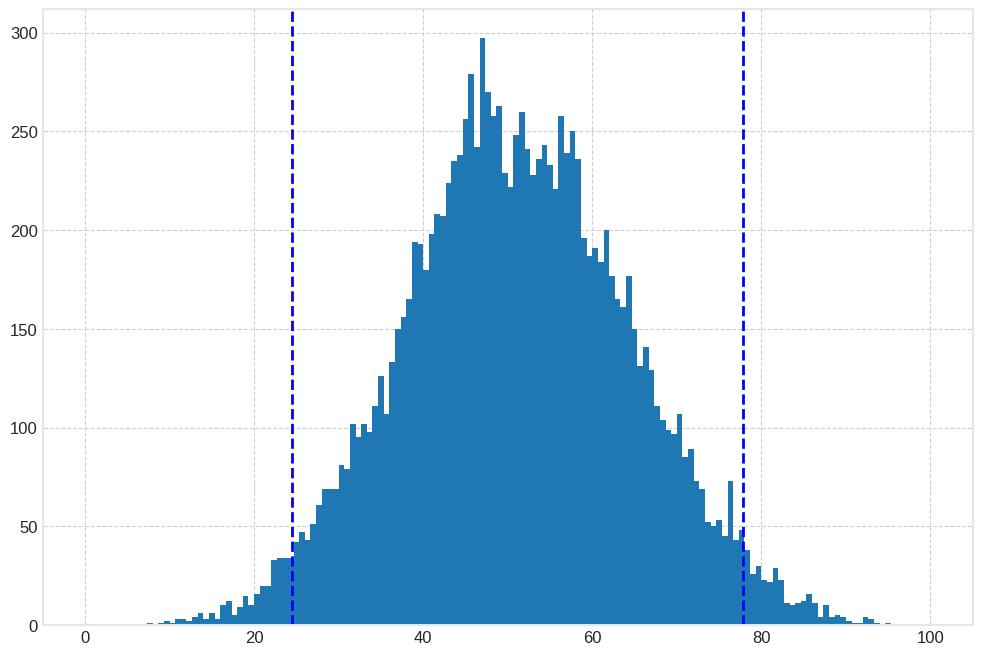

In [22]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [23]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
-1.0    99
 1.0    93
Name: count, dtype: int64

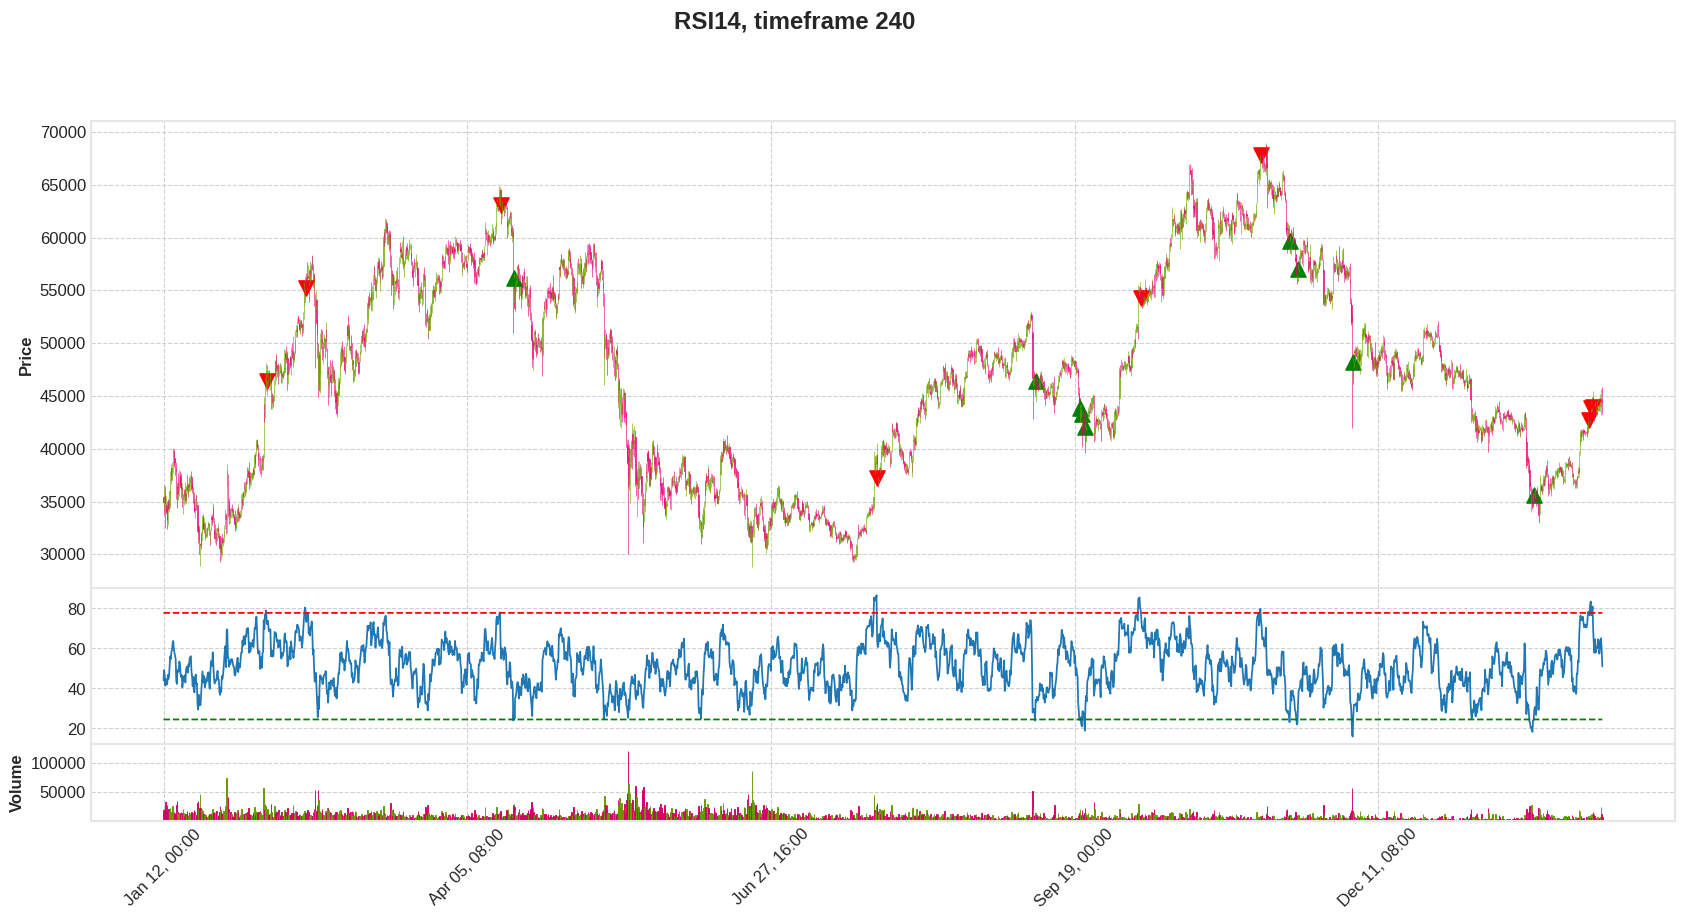

In [24]:
plot_df = df["2021-01-12":"2022-02-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=120, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=120, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [25]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

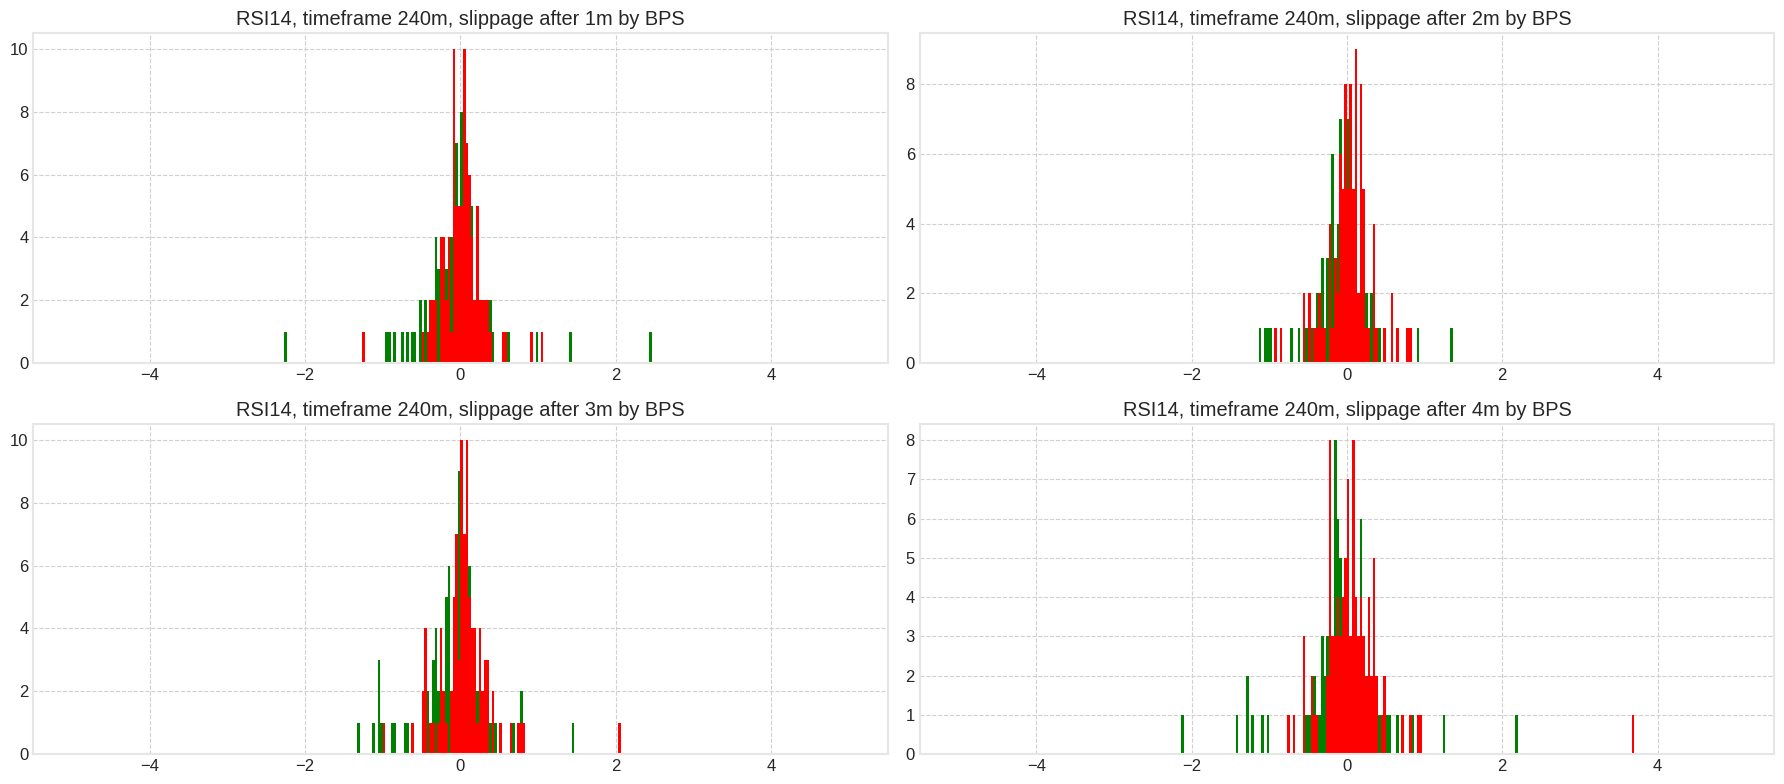

In [26]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-5.0, 5.0)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();

In [27]:
df_ = pd.read_csv("./data/BTCUSDT.csv", parse_dates=True)
df_ = df_.set_index(pd.DatetimeIndex(df_['datetime']))
del df_['datetime']

In [28]:
timeframe_by_hours  = 24
timeframe_by_minute = timeframe_by_hours*60

In [29]:
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4139.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...
2023-07-27,29351.95,29567.49,29083.85,29222.78,22476.476260
2023-07-28,29222.78,29542.22,29123.12,29314.14,23993.616270
2023-07-29,29314.14,29406.92,29256.18,29352.90,10851.368440


mean    : 51.95753072182576
std.dev : 13.895998428043699
sigma lower : 24.2
sigma upper : 79.7


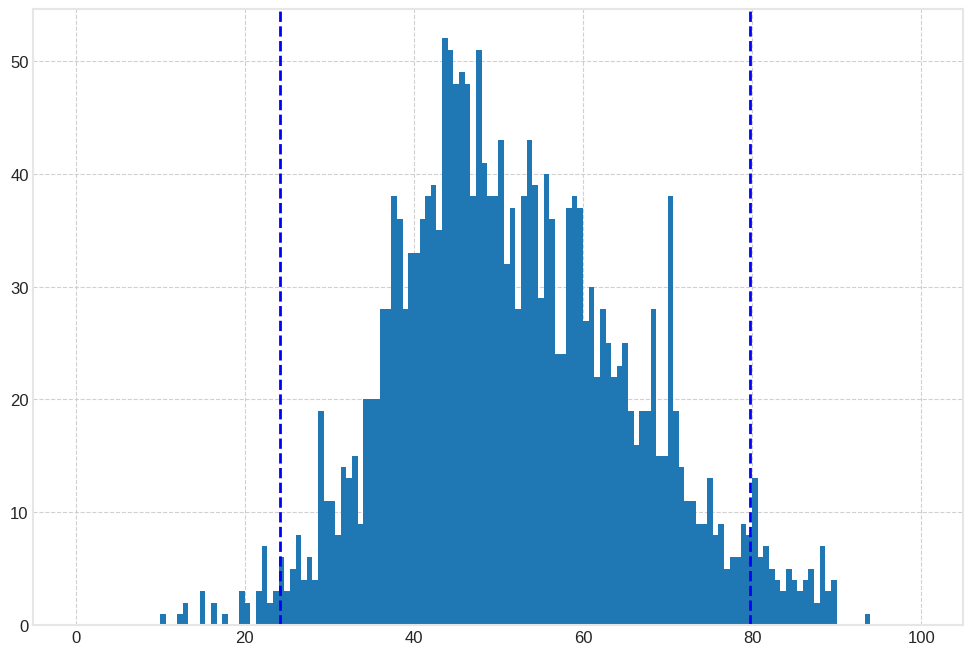

In [30]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [31]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
-1.0    19
 1.0    10
Name: count, dtype: int64

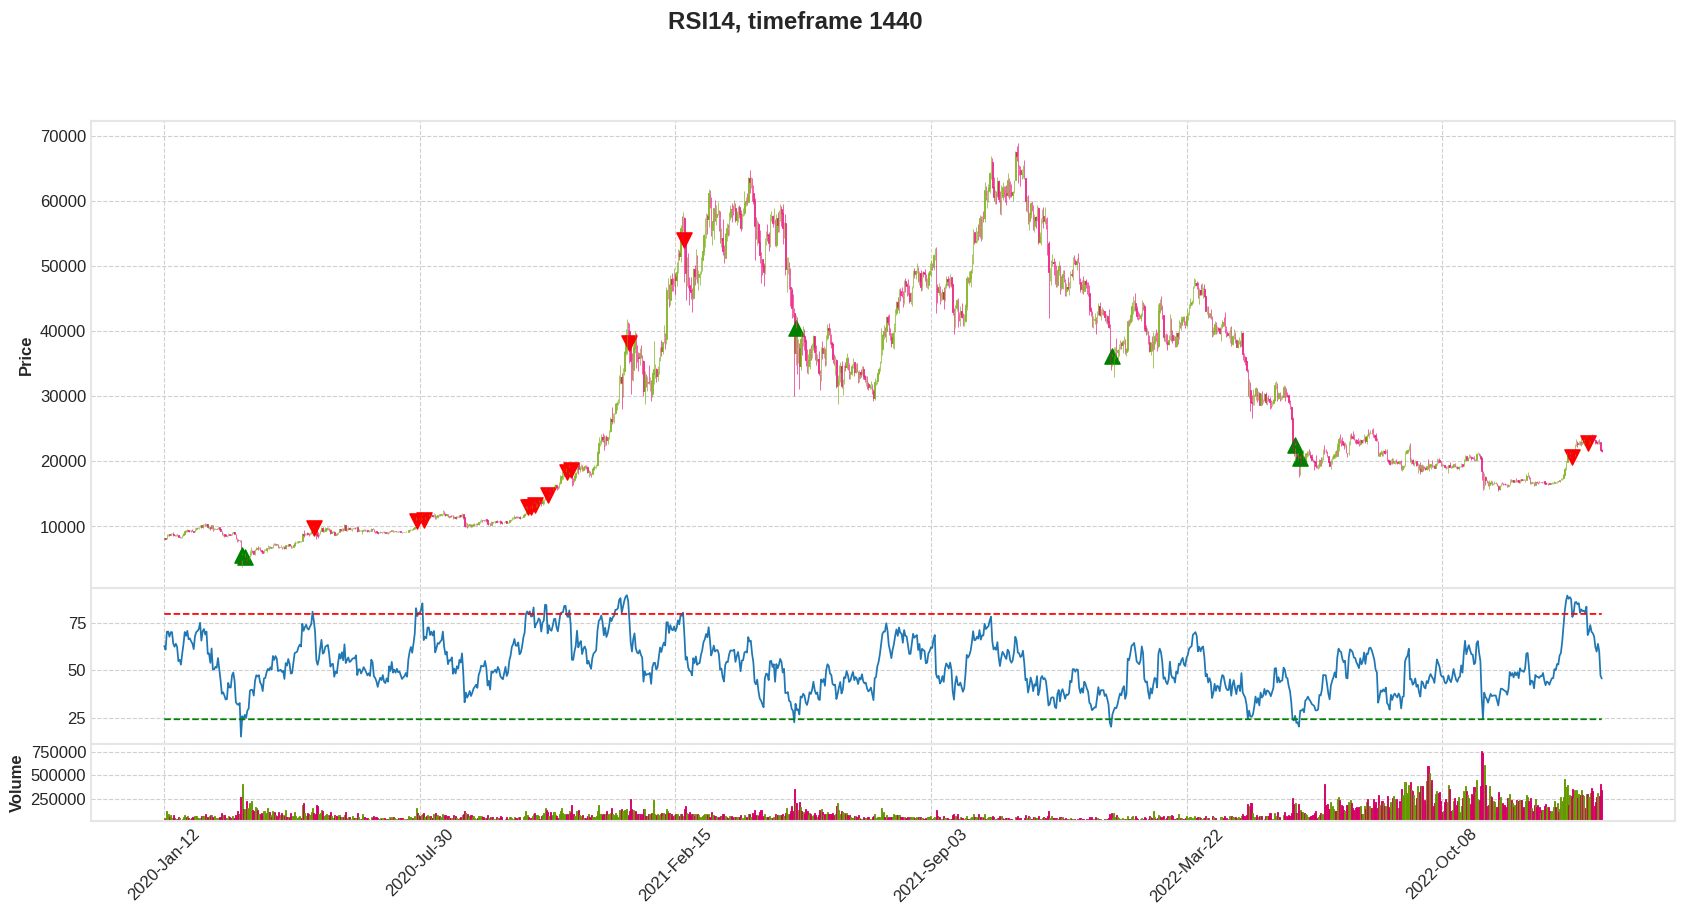

In [32]:
plot_df = df["2020-01-12":"2023-02-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=120, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=120, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"RSI{rsi_period}, timeframe {timeframe_by_minute}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [33]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])

look_ahead_shift = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)

# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 4+1):
    df_eval[f"Close_{executed_after_minute}"            ] = df_eval[f"Close"].shift(-executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}_pct"] = np.nan

# How much changes by percentage occured after order executed
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_pct" ] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"long_entry" ])/df_eval['long_entry' ]
    df_eval[f"short_slippage{executed_after_minute}_pct"] = (df_eval[f"Close_{executed_after_minute}"] - df_eval[f"short_entry"])/df_eval['short_entry']

# Convert slippage by percentage to slippage by bps
for executed_after_minute in range(1, 4+1):
    df_eval[f"long_slippage{executed_after_minute}_bps" ] = (df_eval[f"long_slippage{executed_after_minute}_pct" ]*100.0)
    df_eval[f"short_slippage{executed_after_minute}_bps"] = (df_eval[f"short_slippage{executed_after_minute}_pct"]*100.0)

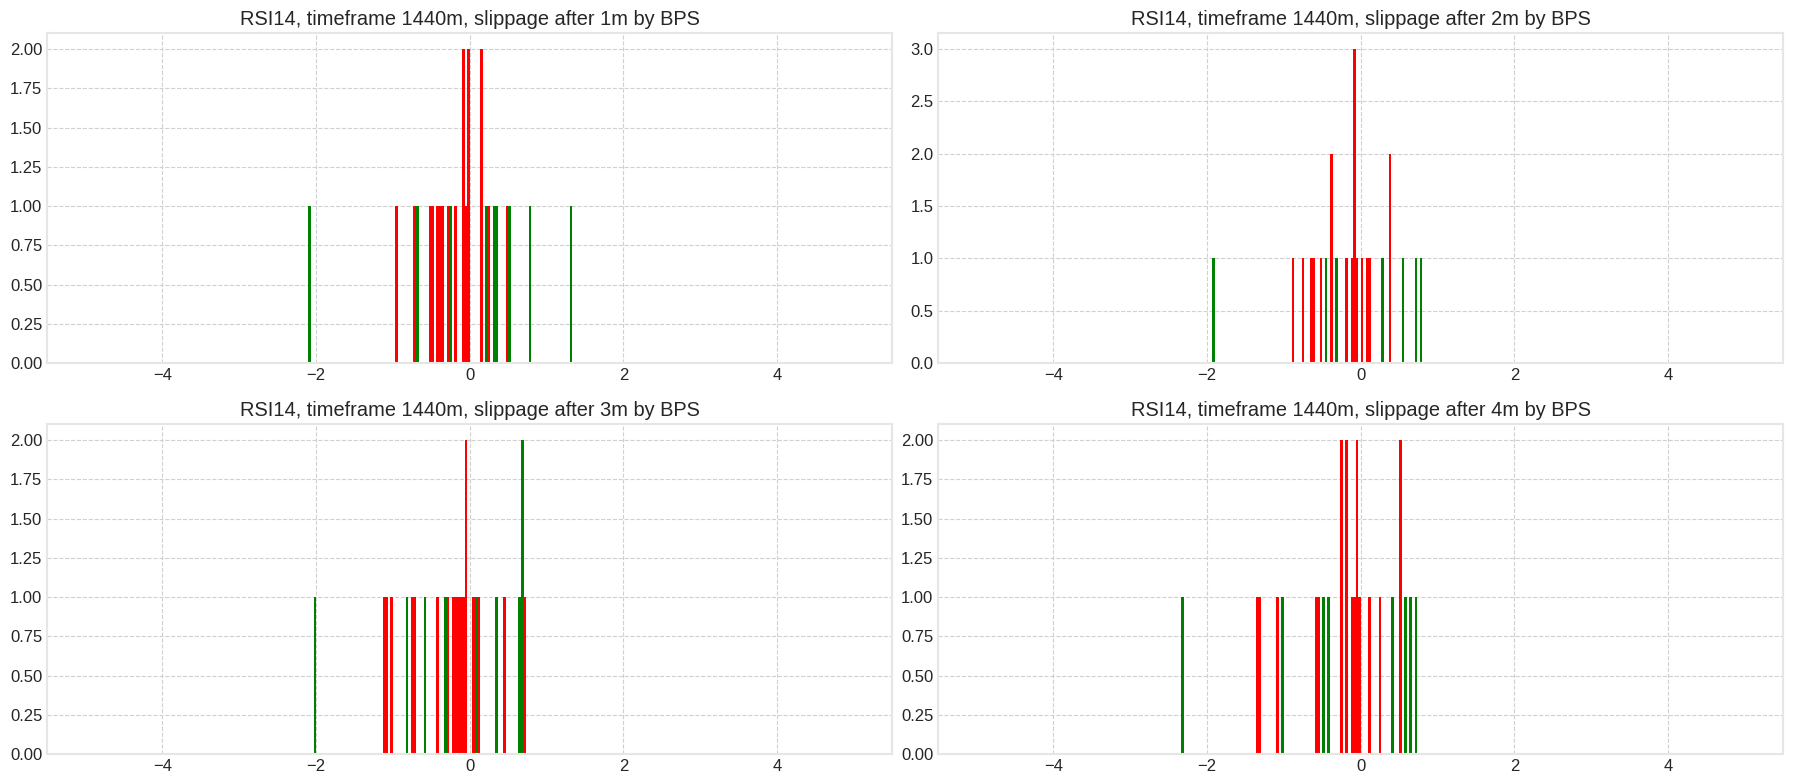

In [34]:
# Slippage by bps distribution after order executed x minutes

_, axs = plt.subplots(2, 2, figsize=(18, 8))

range_by_bps = (-5.0, 5.0)

l11 = axs[0,0].hist(df_eval[df_eval[f"long_slippage1_bps" ].notnull()][f"long_slippage1_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l12 = axs[0,0].hist(df_eval[df_eval[f"short_slippage1_bps"].notnull()][f"short_slippage1_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 1m by BPS")

l21 = axs[0,1].hist(df_eval[df_eval[f"long_slippage2_bps" ].notnull()][f"long_slippage2_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l22 = axs[0,1].hist(df_eval[df_eval[f"short_slippage2_bps"].notnull()][f"short_slippage2_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[0,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 2m by BPS")

l31 = axs[1,0].hist(df_eval[df_eval[f"long_slippage3_bps" ].notnull()][f"long_slippage3_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l32 = axs[1,0].hist(df_eval[df_eval[f"short_slippage3_bps"].notnull()][f"short_slippage3_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,0].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 3m by BPS")

l41 = axs[1,1].hist(df_eval[df_eval[f"long_slippage4_bps" ].notnull()][f"long_slippage4_bps" ].values, bins=300, range=range_by_bps, label="Long slippage BPS" , color='g')
l42 = axs[1,1].hist(df_eval[df_eval[f"short_slippage4_bps"].notnull()][f"short_slippage4_bps"].values, bins=300, range=range_by_bps, label="Short slippage BPS", color='r')
axs[1,1].set_title(f"RSI{rsi_period}, timeframe {timeframe_by_minute}m, slippage after 4m by BPS")

plt.tight_layout()
plt.show();